In [2]:
#Author: James Negus

import math
import os
import glob
import csv
import shutil

from math import log10, floor

import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones
from numpy import exp, linspace, random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText

from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a

# from uncertainties import unumpy
# from uncertainties import ufloat

import pylab as plb

from scipy.optimize import curve_fit
from scipy.optimize import leastsq as lmfitter
from scipy import signal
from scipy import asarray as ar,exp
from scipy.stats import chisquare
from scipy.stats import stats
from scipy.integrate import quad
from scipy.stats import linregress

import scipy.io
import scipy.integrate as integrate

from IPython.display import display, Math

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

#import sherpa.ui as ui
import pandas as pd
from sklearn.linear_model import LinearRegression

# import marvin
# #from marvin.tools import Maps
# from marvin.utils.general.images import showImage
# from marvin.tools.cube import Cube
# from marvin import config

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

%matplotlib inline

#Emission Lines (Vacuum)

OVI = 1033.82 
Ly_Alpha = 1215.24  
NV = 1240.81  
OI = 1305.53  
CII = 1335.31  
Si_IV = 1397.61  
Si_IV_O_IV = 1399.8  
CIV = 1549.48  
He_II = 1640.4
OIII = 1665.85 
Al_III = 1857.4 
CIII = 1908.734 
CII = 2326.0 
Ne_IV = 2439.5 
Mg_II = 2799.117 
NeV_3346 = 3346.79 #*
Ne_VI = 3426.85 
FeVII_3586 = 3586 #*
OII_1 = 3727.092 ###
OII_2 = 3729.875  
FeVII_3760 = 3760 #*
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
FeVII_6086 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  ###
FeX_6374 = 6374 #* Very hard to detect because it is so weak. 
NI = 6529.03  
NII_1 = 6549.86 
H_Alpha = 6564.614  
NII_2 = 6585.27  
SII = 6718.29  
SII = 6732.67  

#Absorption Lines

K = 3934.777  
H = 3969.588 
G = 4305.61  
Mg = 5176.7  
Na = 5895.6  
CaII_1 = 8500.36  
CaII_2 = 8544.44  
CaII_3 = 8664.52  

#Sky Lines

Sky_1 = 5578.5 
Sky_2 = 5894.6  
Sky_3 = 6301.7  
Sky_4 = 7246.0 

c = 299792 #speed of light km/s 

In [3]:
counter = 0
for plate in chain(range(10516, 10520, 1)):
# for plate in chain(range (7443, 7444, 1), range (7495, 7496, 1), range(7815,7816, 1), range(7957,7994, 1), range(8077,8098, 1), 
#                    range(8131,8159, 1), range(8239, 8275, 1), range(8309, 8487, 1),
#                    range(8547, 8658, 1), range(8711, 8729, 1), range(8931, 9096, 1),
#                    range(9181, 9197, 1), range(9485, 9515, 1), range(9862, 9895, 1), 
#                    range(10001, 10002, 1), range(10141, 10148, 1), range(10213, 10222, 1), range(10492, 10520, 1)):
    #                      range(9673, 9679, 1),    
    
 #   
    for ifu in chain(range (1902,1903, 1), range(3701, 3705, 1),  
                     range (6101, 6105, 1), range(9101, 9103, 1), range(12701, 12706, 1)):
        
#     for ifu in chain(range (1901,1903, 1), range(3701, 3705, 1), 
#                      range (6101, 6105, 1), range(9101, 9103, 1), range(12701, 12706, 1)):

        os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
              'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
              +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
              +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz output/')
#         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
#                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
#                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
#                   +'-MAPS-VOR10-GAfU-MILESHC.fits.gz Test/')
        os.system('gunzip output/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz')
#        os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-GAU-MILESHC.fits.gz')

        def emission(emline, bounds, emline_name):
            for fitsName in glob.glob('output/*.fits'):
                
                hdulist = fits.open(fitsName) 
                wavelength_import = hdulist[4].data #Importing Wavelength Values
                flux_import = hdulist[1].data
                
                drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
                tbdata = drpall[1].data #Accessing drpall data
                ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
                iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
                plateifu1 = tbdata['plateifu'][ind][0]
                
                wavelength = wavelength_import/(tbdata['z'][ind][0] + 1)
                
                if emline == NeV_3346 and tbdata['z'][ind][0] < 0.0821073:
                    hdulist.close()
                    drpall.close()  
                    break
                
                index1,index2,index3 = flux_import.shape
                cp = int(index2/2)
                cp_down = cp-3
                cp_up = cp+3
                pd = int(index3/2)
                p_down = pd-3
                p_up = pd+3
                
                #Nuclear region flux
                flux_nuclear_dimensions = flux_import[:,cp_down:cp_up,p_down:p_up]
                flux_nuclear_sum = flux_nuclear_dimensions.sum(axis = (0))
                flux = flux_nuclear_dimensions.sum(axis = (1, 2))
                
                #Galaxy flux
                flux_galaxy = flux_import.sum(axis = (0))
                flux_galaxy_1d = flux_import.sum(axis = (1,2))
                
                #Defining neighboring wavelengths
                wavelength_absolute = np.abs(wavelength - emline) 
                wavelength_min = np.argmin(wavelength_absolute)
                
                #FeVII_3076 Neighboring Lines
                wavelength_oii1 = np.abs(wavelength - OII_1) 
                wavelength_min_oii1 = np.argmin(wavelength_oii1)
                wavelength_oii2 = np.abs(wavelength - OII_2) 
                wavelength_min_oii2 = np.argmin(wavelength_oii2)
                wavelength_hei = np.abs(wavelength - He_I) 
                wavelength_min_hei = np.argmin(wavelength_hei)
                
                #FeVII_6086 Neighboring Lines
                wavelength_na = np.abs(wavelength - Na) 
                wavelength_min_na = np.argmin(wavelength_na) 
            
                #FeX_6374 Neighboring Lines
                wavelength_oi1 = np.abs(wavelength - OI_1) 
                wavelength_min_oi1 = np.argmin(wavelength_oi1)
                wavelength_oi2 = np.abs(wavelength - OI_2) 
                wavelength_min_oi2 = np.argmin(wavelength_oi2)
                wavelength_ni = np.abs(wavelength - NI) 
                wavelength_min_ni = np.argmin(wavelength_ni)
                wavelength_nii1 = np.abs(wavelength - NII_1) 
                wavelength_min_nii1 = np.argmin(wavelength_nii1)
                wavelength_nii2 = np.abs(wavelength - NII_2) 
                wavelength_min_nii2 = np.argmin(wavelength_nii2)
                wavelength_halpha = np.abs(wavelength - H_Alpha) 
                wavelength_min_halpha = np.argmin(wavelength_halpha)
                
                #NeV_3346 Neighboring Lines
                wavelength_nevi = np.abs(wavelength - Ne_VI) 
                wavelength_min_nevi = np.argmin(wavelength_nevi)
                
                #H-Alpha Neighboring Lines
                wavelength_oiii3 = np.abs(wavelength - OIII_3) 
                wavelength_min_oiii3 = np.argmin(wavelength_oiii3)
                
                #Determining observed (for vmeasured value)
            #         lambda_obs = (tbdata['z'][ind][0] + 1)*emline
            #         wavelength_absolute = np.abs(wavelength - lambda_obs) 
            #         wavelength_min = np.argmin(wavelength_absolute)

                #Spectrum parameters
                y_0, y_1 = wavelength_min - bounds, wavelength_min + bounds #Setting lower/ upper bound for linear fit
                if y_0 < 0:
                    y_0 = 0

                #Performing linear fit
                
                l_i = bounds #Bounds of fit
                x_0 = wavelength_min - l_i #Setting lower bound for linear fit
                if x_0 < 0:
                    x_0 = 0
                x_1 = wavelength_min + l_i #Setting upper bound for linear fit
                z_1_2 = x_0 - 10*l_i
                if z_1_2 < 0:
                    z_1_2 = 0
                x_1_2 = x_1 + 10*l_i

                wavelength_bounds_total = wavelength[z_1_2:x_1_2] 
                wavelength_total = np.abs(wavelength_bounds_total - emline) 
                wavelength_min_total = np.argmin(wavelength_total)
                
                wavelength_mask_total = np.ma.masked_array(wavelength_bounds_total,
                                                     (wavelength_bounds_total != wavelength_bounds_total[0])& 
                                                     (wavelength_bounds_total != wavelength_bounds_total[-1])) 
                wavelength_compressed_total = wavelength_mask_total.compressed() 
                
                flux_bounds_total = flux[z_1_2:x_1_2] 
                flux_mask_total = np.ma.masked_array(flux_bounds_total, (flux_bounds_total != flux_bounds_total[0]) 
                                           & (flux_bounds_total != flux_bounds_total[-1]))
                flux_compressed_total = flux_mask_total.compressed() 
                
                if flux_compressed_total.shape[0] == 3:
                    print ('duplicate')
                    flux_1 = flux_compressed_total[0]
                    flux_2 = flux_compressed_total[2]
                    flux_compressed_total = [flux_1, flux_2]
                
                if flux_compressed_total[0] != 0:
        
                    polyfit_total = np.polyfit(wavelength_compressed_total,flux_compressed_total, 1) #Fitting the line to the data
                    fit_total = np.poly1d(polyfit_total)
                    flux_linear_total = fit_total[1]*wavelength_bounds_total + fit_total[0] #Determining linear fit parameters
                    flux_correction_total = flux_bounds_total - flux_linear_total #Correcting for continuum
                    
                    for i in flux_correction_total:
                        if i < 0:
                            negative = np.argmin(flux_correction_total)
                            flux_correction_total = flux_correction_total + abs(flux_correction_total[negative])
                            break

                    x_1_9 = x_1 + 4*l_i
                    flux_sigma_bounds_1 = flux[x_1 + 5: x_1_9 + 5]
                    f_std = np.std(flux_sigma_bounds_1)
                    flux_sigma = 5*(f_std)
                    
                    if len(fitsName) == 57:
                        print ('\n' + iau + ' ('+ fitsName[13:22] + ') ' + emline_name + ' ' +
                               '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma) + '\n' +
                                emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(flux_correction_total[wavelength_min_total]))
                    if len(fitsName) == 58:
                        print ('\n' + iau + ' (' + fitsName[13:23] + ') ' + emline_name + ' ' +
                               '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma) + '\n' +
                                emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(flux_correction_total[wavelength_min_total]))
                    if len(fitsName) == 59:
                        print ('\n' + iau + ' (' + fitsName[13:24] + ') ' + emline_name + ' ' +
                               '\n' + 'Five Sigma (ergs/cm^2/A/spaxel) = ' + str(flux_sigma) + '\n' +
                                emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(flux_correction_total[wavelength_min_total]))

                    q_0 = wavelength_min_total - l_i
                    if q_0 < 0:
                        q_0 = 0
                    q_1 = wavelength_min_total + l_i
                    wavelength_bounds = wavelength_bounds_total[q_0:q_1]
                    flux_bounds = flux_correction_total[q_0:q_1]
                    
                    polyfit = np.polyfit(wavelength_bounds,flux_bounds, 1) #Fitting the line to the data
                    fit = np.poly1d(polyfit)
                    
                    def gaus(x,amp,mu,sigma, m, c):
                        return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function

#                     for i in flux_bounds[l_i:]:
#                         if i < 0.6827*flux_bounds[l_i]:
#                             s = np.abs(flux_bounds - i)
#                             s2 = np.argmin(s)
#                             sigma_guess = np.abs(wavelength_bounds[s2] - wavelength_bounds[l_i])
#                             break
#                         else: 
#                             continue
#                     try:
#                         sigma_guess

#                     except NameError:
#                         hdulist.close()
#                         drpall.close()   
#                         print ('failed sigma guess')
#                         break
 
                    p_i = wavelength_bounds.shape[0]
                    wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)
                    
                    mu=np.sum(wavelength_bounds*flux_bounds)/np.sum(flux_bounds)
                    sigma_guess = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu)**2)/np.sum(flux_bounds))
                    
                    popt, pcov = curve_fit(gaus,wavelength_bounds, 
                                       flux_bounds,  
                                       p0=[flux_bounds[l_i], 
                                           mu, sigma_guess, fit[1], fit[0]])
                
                    velocity_meas = c*((popt[1] - emline)/emline)
                    velocity_sys = c*tbdata['z'][ind][0]
                    velocity_off = velocity_sys - velocity_meas
                    sigma = c*(popt[2]/emline)

#                 #             f= open(str(emline_name) + ".txt","a+")
#                 #             f.write('\t' + fitsName[11:-31] +'\t' + str(round(tbdata['z'][ind][0],3)) + '\t' +
#                 #                     str(round(popt[0],3)) + '\t' + str(round(velocity_meas, 3)) + '\t' +
#                 #                     str(round(velocity_sys,3)) + '\t' + str(round(velocity_off,3)) + '\t'
#                 #                     + str(round(sigma,3)) + '\n') 
#                 #             f.close() 

#                         anchored_gaussian = AnchoredText('Amplitude  = ' + str(popt[0])  
#                                                + '\n' + '\n' + 'Sigma (km/s) = ' + str(sigma) + '\n' 
#                                                , loc=4)
                    sigma_threshold = ((2000/2.355)/c)*(wavelength[wavelength_min])
            #        print (' Gaussian Sigma (km/s) = ' + str(sigma))

#                         #Wavelength vs Flux


                    if sigma > 0 and sigma < 500 and popt[0] > flux_sigma:
                            newpath = r'/Users/jamesnegus/Google Drive/Academic/CU/Research/manga/primary_code/output/5_sigma/%s/'%emline_name + '%s/'%iau
                            if not os.path.exists(newpath):
                                os.makedirs(newpath)
                            f = open(newpath + "gaussian.csv","w+")
                            f.write('SDSS Name' + ',' + 'Redshift' + ',' + 'Amplitude ' + ','+ 'Sigma (km/s)' + ',' + 'Measured Velocity(km/s)' +
                                    '\n' + str(iau) + ',' + str(round_sig(tbdata['z'][ind][0], 2)) + ','  + str(round_sig(popt[0], 2))+ ','  
                                    + str(round_sig(sigma, 2)) + ','  + str(round_sig(velocity_meas, 2)))
                            f.close()

                            marker = np.argmin(flux_correction_total)

                            plt.figure(figsize=(15,10))
                            plt.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')

                            if len(fitsName) == 57:
                                plt.title(iau + ' ('+ fitsName[13:22] + ') ' + ' / z = ' 
                                      + str(tbdata['z'][ind][0]))
                            if len(fitsName) == 58:
                                plt.title(iau + ' ('+ fitsName[13:23] + ') ' + ' / z = ' 
                                      + str(tbdata['z'][ind][0]))
                            if len(fitsName) == 59:
                                plt.title(iau + ' ('+ fitsName[13:24] + ') ' + ' / z = ' 
                                      + str(tbdata['z'][ind][0]))

                            plt.ylabel('Flux', fontsize = 15)
                            plt.xlabel(r'Wavelength ($\AA$)', fontsize = 15)
                            r = wavelength_bounds_total.shape
                            plt.xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])

                            if emline == FeVII_3586:
                                plt.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                                plt.text(wavelength[wavelength_min-4], -0.15, 'FeVII', fontsize=9)
                                
                            if emline == FeVII_3760:
                                plt.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                                plt.text(wavelength[wavelength_min-4], -0.15, 'FeVII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_oii1],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                                plt.text(wavelength[wavelength_min_oii1-3], -0.15, 'OII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_oii2],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                                plt.text(wavelength[wavelength_min_oii2-3], -0.15, 'OII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_hei],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                                plt.text(wavelength[wavelength_min_hei-3], -0.15, 'OII', fontsize=9)
                                plt.text(wavelength[x_1 + 15], -0.15, 'Neighboring Continuum', fontsize=9)

                            if emline == FeVII_6086:
                                plt.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                                plt.text(wavelength[wavelength_min-4], -0.15, 'FeVII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_na],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                                plt.text(wavelength[wavelength_min_na-2], -0.15, 'Na', fontsize=9)
                                plt.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                                plt.text(wavelength[wavelength_min_oi1-2], -0.15, 'OI', fontsize=9)
                                plt.text(wavelength[x_1 + 15], -0.15, 'Neighboring Continuum', fontsize=9)

                            if emline == FeX_6374:
                                plt.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                                plt.text(wavelength[wavelength_min-3], -1, 'FeX', fontsize=9)
                                plt.plot(wavelength[wavelength_min_oi2],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
                                plt.text(wavelength[wavelength_min_oi2-2], -1, 'OI', fontsize=9)
                                plt.plot(wavelength[wavelength_min_oi1],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                                plt.text(wavelength[wavelength_min_oi1-2], -1, 'OI', fontsize=9)
                                plt.plot(wavelength[wavelength_min_ni],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
                                plt.text(wavelength[wavelength_min_ni-2], -1, 'NI', fontsize=9)
                                plt.plot(wavelength[wavelength_min_nii1],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
                                plt.text(wavelength[wavelength_min_nii1-3], -1, 'NII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_nii2],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
                                plt.text(wavelength[wavelength_min_nii2-3], -1, 'NII', fontsize=9)
                                plt.plot(wavelength[wavelength_min_halpha],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
                                plt.text(wavelength[wavelength_min_halpha-6], -1, 'Halpha', fontsize=9)
                                plt.text(wavelength[x_1 + 15], -1.5, 'Neighboring Continuum', fontsize=9)

#                             if emline == OIII_4:
#                                 plt.plot(wavelength[wavelength_min_oiii3],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
#                                 plt.text(wavelength[wavelength_min_oiii3-4], -1, 'OIII', fontsize=9)
#                                 plt.text(wavelength[x_1 + 15], -1, 'Neighboring Continuum', fontsize=9)

                            if emline == NeV_3346:
                                plt.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
                                plt.text(wavelength[wavelength_min-3], -1.5, 'NeV', fontsize=9)
                                plt.plot(wavelength[wavelength_min_nevi],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
                                plt.text(wavelength[wavelength_min_nevi-4], -1.5, 'Ne_VI', fontsize=9)
                                plt.text(wavelength[x_1 + 15], -1.5, 'Neighboring Continuum', fontsize=9)

                            plt.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
                            plt.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
                            plt.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
                            plt.axvline(x = wavelength[x_1_9 + 5], linestyle = '-', color = 'k')
                            plt.plot(wavelength_range, 
                                     gaus(wavelength_range, *popt), 'r-', label = 'Gaussian')
                            plt.legend(loc = 1)

                            plt.savefig(newpath + iau + '_' + emline_name + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                            #plt.show()

                            #Emission Line Flux Maps
                            f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                            cax1 = ax1.imshow(flux_import[y_0:y_1, :, :].sum(axis = 0), cmap='magma', origin = 'lower')
                            ax1.set_title(iau  + ' ' + emline_name + ' ' + ' Galaxy Flux Map')
                            ax1.set_xlabel('Spaxels')
                            ax1.set_ylabel('Spaxels')
                            f.colorbar(cax1, ax = ax1, label = 'Flux')
                            cax2 = ax2.imshow(flux_nuclear_dimensions[y_0:y_1, :, :].sum(axis = (0)), cmap='magma', origin = 'lower')
                            ax2.set_title(iau  + ' ' + emline_name + ' ' + ' Nuclear Flux Map')
                            ax2.set_xlabel('Spaxels')
                            ax2.set_ylabel('Spaxels')
                            f.colorbar(cax2, ax = ax2, label = 'Flux')
                            f.savefig(newpath +  iau + '_' + 'emission_line_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                            #plt.show()

                            #Continuum Flux Maps
                            f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,8))
                            cax1 = ax1.imshow(flux_galaxy, cmap='magma', origin = 'lower')
                            ax1.set_title(iau + ' Continuum Galaxy Flux Map')
                            ax1.set_xlabel('Spaxels')
                            ax1.set_ylabel('Spaxels')
                            f.colorbar(cax1, ax = ax1, label = 'Flux')
                            cax2 = ax2.imshow(flux_nuclear_sum, cmap='magma', origin = 'lower')
                            ax2.set_title(iau + ' Continuum Nuclear Flux Map')
                            ax2.set_xlabel('Spaxels')
                            ax2.set_ylabel('Spaxels')
                            f.colorbar(cax2, ax = ax2, label = 'Flux')
                            f.savefig(newpath +  iau + '_' + 'continuum_flux_maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
                            #plt.show()


                             # get a map
                            #maps = Maps(plateifu=plateifu1)

                            # make a standard 3-plot BPT and retrieve the classifications
                            #masks, fig, axes = maps.get_bpt()

                            # save the plot
                            #fig.savefig(dir + iau + '_' + '3_plot_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

#                             # make a BPT classification without OI
#                             masks, fig, axes = maps.get_bpt(use_oi=False)
#                             # save the plot
#                             fig.savefig(dir + iau + 'no_OI_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
    
                hdulist.close()
                drpall.close()               

            return;
            

        # Calling the function
        emission(emline = FeVII_3586, 
                 bounds = 15, 
                 emline_name = 'FeVII_3586A')
        emission(emline = FeVII_3760, 
                 bounds = 15, 
                 emline_name = 'FeVII_3760A')
        emission(emline = FeVII_6086, 
                bounds = 15, 
                emline_name = 'FeVII_6086A')
        emission(emline = FeX_6374, 
                bounds = 15, 
                emline_name = 'FeX_6374A')
        emission(emline = NeV_3346, 
                 bounds = 15,  
                 emline_name = 'NeV_3346.79A')
#         emission(emline = H_Beta, 
#                 bounds = 15, 
#                 emline_name = 'HBeta_4862.68A')
#         emission(emline = OIII_4, 
#                 bounds = 15, 
#                 emline_name = 'OIII_4_5008.240A')
        
        for fitsName in glob.glob('output/*.fits'):
            counter += 1
            print ('\n' + 'Galaxy Counter: ' + str(counter)) 
            os.remove(fitsName)                    




J100620.17+030728.2 (10516-1902) FeVII_3586A 
Five Sigma (ergs/cm^2/A/spaxel) = 9.725034832954407
FeVII_3586A Flux (ergs/cm^2/A/spaxel) = 1.7385063
0.82543945
7.7318034

J100620.17+030728.2 (10516-1902) FeVII_3760A 
Five Sigma (ergs/cm^2/A/spaxel) = 17.37459897994995
FeVII_3760A Flux (ergs/cm^2/A/spaxel) = 8.8727455
10.40332
6.582788


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

['plate', 'ifudsgn', 'plateifu', 'mangaid', 'versdrp2', 'versdrp3', 'verscore', 'versutil', 'versprim', 'platetyp', 'srvymode', 'objra', 'objdec', 'ifuglon', 'ifuglat', 'ifura', 'ifudec', 'ebvgal', 'nexp', 'exptime', 'drp3qual', 'bluesn2', 'redsn2', 'harname', 'frlplug', 'cartid', 'designid', 'cenra', 'cendec', 'airmsmin', 'airmsmed', 'airmsmax', 'seemin', 'seemed', 'seemax', 'transmin', 'transmed', 'transmax', 'mjdmin', 'mjdmed', 'mjdmax', 'gfwhm', 'rfwhm', 'ifwhm', 'zfwhm', 'mngtarg1', 'mngtarg2', 'mngtarg3', 'catidnum', 'plttarg', 'manga_tileid', 'nsa_iauname', 'ifudesignsize', 'ifutargetsize', 'ifudesignwrongsize', 'z', 'zmin', 'zmax', 'szmin', 'szmax', 'ezmin', 'ezmax', 'probs', 'pweight', 'psweight', 'psrweight', 'sweight', 'srweight', 'eweight', 'esweight', 'esrweight', 'nsa_field', 'nsa_run', 'nsa_camcol', 'nsa_version', 'nsa_nsaid', 'nsa_nsaid_v1b', 'nsa_z', 'nsa_zdist', 'nsa_sersic_absmag', 'nsa_elpetro_absmag', 'nsa_elpetro_amivar', 'nsa_sersic_mass', 'nsa_elpetro_mass', 'ns

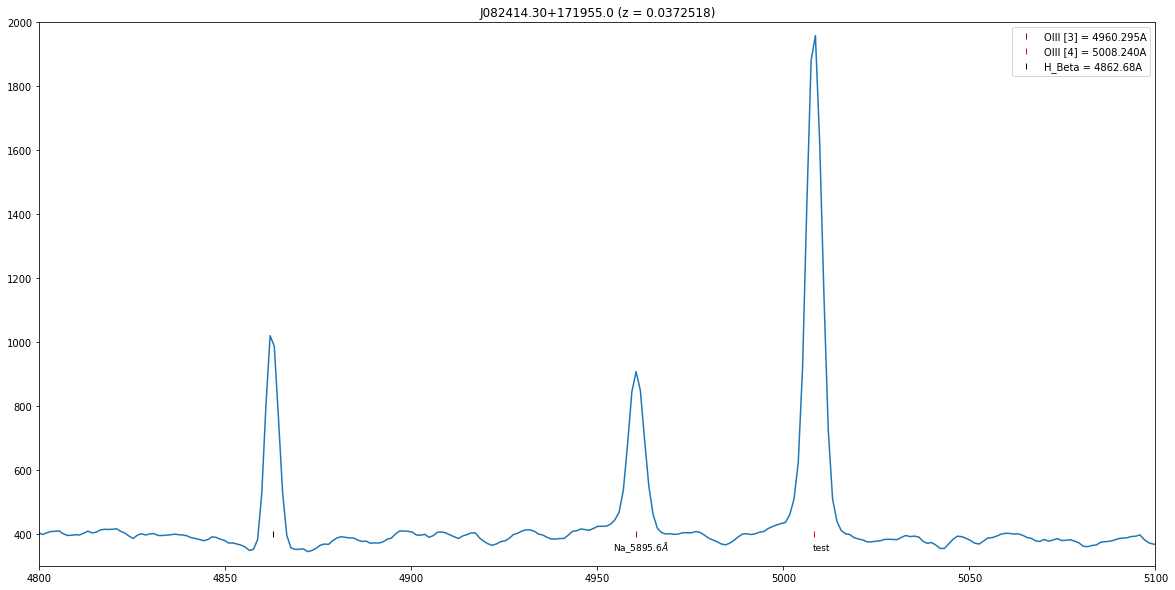

In [3]:
hdulist = fits.open('manga-8241-6102-LOGCUBE-VOR10-MILESHC-MILESHC.fits') #Opening fits file
# flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
flux = hdulist[1].data #Importing Flux Values 
wavelength_raw = hdulist[4].data #Importing Wavelength Values
drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
tbdata = drpall[1].data #Accessing drpall data
print (tbdata.columns.names)
ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
iau = tbdata['nsa_iauname'][ind][0] 
wavelength = wavelength_raw/(tbdata['z'][ind][0] + 1)
c = 299792 #speed of light km/s 
hdulist.close()
drpall.close()

i,o,p = flux.shape
cp = int(o/2)
cp_down = cp-3
cp_up = cp+3
p = int(p/2)
p_down = p-3
p_up = p+3
#print (cp_down, cp_up, p_down, p_up)

y = flux[:,cp_down:cp_up,p_down:p_up]
test2 = y.sum(axis = (1, 2))
test32 = flux.sum(axis = (1, 2))
plt.figure(figsize=(20,10))
plt.plot (wavelength, test32)
plt.title(iau + ' (z = ' + str(tbdata['z'][ind][0]) + ')')
plt.xlim(4800,5100)
plt.ylim(300,2000)
plt.plot(4960.295,400, marker='|', color = 'purple', label = "OIII [3] = 4960.295A", linestyle='None')
plt.text(4954.295, 350, 'Na_5895.6$\AA$', fontsize=9)
plt.plot(5008.240,400, marker='|', color = 'red', label = "OIII [4] = 5008.240A", linestyle='None')
plt.text(5008, 350, 'test', fontsize=9)
plt.plot(4862.68,400, marker='|', color = 'black', label = "H_Beta = 4862.68A", linestyle='None')
plt.legend()
plt.show()

# plt.xlim(5900,6350)
# plt.ylim(40,75)
# # plt.plot(4960.295,40, marker='|', color = 'purple', label = "OIII [3] = 4960.295A", linestyle='None')
# plt.plot(6302.046,42, marker='|', color = 'red', label = "OI_1 = 6302.046", linestyle='None')
# plt.plot(6086,42, marker='|', color = 'black', label = "Fe_VII_3 = 6086A", linestyle='None')
# plt.legend()
# plt.show()


# #q = np.where(wavelength = )
# test3 = abs(wavelength - OIII_4)
# test_min = np.argmin(test3) 
# #print(wavelength[test_min], test_min)
# #print (test3)
# # print (wavelength[1555], wavelength[1579])
# # print (wavelength[1580] - wavelength[1554])
# po = flux[25:54, :, :].sum(axis = 0)
# #print (po.shape)
# #flux_galaxy = flux_import.sum(axis = (0))
# #print (flux.shape)
# test = flux[:, :, :].sum(axis = (0))
# u,a = test_min - 30, test_min + 30
# #print (u, a)
# test54 = flux[u:a, :, :].sum(axis = (0))
# # #print (flux.shape)
# # #print (wavelength.shape)

# # plt.figure(figsize=(20,10))
# # plt.plot (test32[u:a])
# # plt.show()

# #fig = plt.figure()
# f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(20,8))
# cax1 = ax1.imshow(test, cmap='magma', origin = 'lower')
# ax1.set_title('Flux Map')
# ax1.set_xlabel('Spaxels')
# ax1.set_ylabel('Spaxels')
# f.colorbar(cax1, ax = ax1, label = 'Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# #f.colorbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# cax2 = ax2.imshow(test54, cmap='magma', origin = 'lower')
# ax2.set_title('Flux Map')
# ax2.set_xlabel('Spaxels')
# ax2.set_ylabel('Spaxels')
# f.colorbar(cax2, ax = ax2, label = 'Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# #f.savefig('nuclear_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)






The LOGCUBE files provide the binned spectra and the best-fitting model spectrum for each spectrum that was successfully fit. These files are useful for detailed assessments of the model parameters because they allow you to return to the spectra and compare the model against the data.

The DAP fits the spectra in two stages, one to get the stellar kinematics and the second to determine the emission-line properties. The emission-line module (used for all binning schemes) fits both the stellar continuum and the emission lines at the same time, where the stellar kinematics are fixed by the first fit. The difference between the stellar-continuum fit during the first and second fit are provided by the EMLINE_BASE extension. I.e., if you want to get the stellar-continuum models from the first fit, you calculate:

stellar_continuum = MODEL - EMLINE - EMLINE_BASE

Primary - Empty extension with primary header information.

Flux (10^(-17) erg/s/cm2/angstrom/spaxel) - Flux of the binned spectra.

IVAR - Inverse variance in the binned spectra.

MASK - Bitmask for the binned and model spectra.

WAVE (Angstrom) - Vacuum-wavelength vector.

REDCORR - Reddening correction applied during the fitting procedures; dereddened_flux = FLUX * REDCORR.

MODEL (10^(-17) erg/s/cm2/angstrom/spaxel) - The best fitting model spectra (sum of the fitted continuum and emission-line models).

EMLINE (10^(-17) erg/s/cm2/angstrom/spaxel) - The model spectrum with only the emission lines.

EMLINE_BASE	(10^(-17) erg/s/cm2/angstrom/spaxel) - The adjustment to the stellar continuum made during the combined continuum + emission-line fit.

EMLINE_MASK - The bitmask that only applies to the emission-line modeling.

BINID - Numerical ID for spatial bins in 5 channels: (1) binned spectra, (2) stellar-continuum results, (3) empty, (4) emission-line model results, and (5) empty; i.e., channels 1, 2, and 4 are the same as the BINID extension in the MAPS files and channels 3 and 5 are empty.



In [ ]:
#Creating .txt file for table that lists emission line parameters
#for fitsName in glob.glob('cg/vor10/*.fits'):

# def emission_1(em):
#     f= open(str(em) + ".txt","a+")
#     f.write(em + '\n' + 'SDSS Name' + '\t' + 'MaNGA ID' + '\t' + 'z' 
#             + '\t' + 'Flux (erg/s/cm2/A/spaxel)' + '\t' + 
#             'V_meas (km/s)' + '\t' + 'V_sys (km/s)' 
#             + '\t' + 'V_off (km/s)' + '\t' + 'Sigma (km/s)' + '\n')
#     f.close()
#     return;
# emission_1(em = 'HBeta')
# emission_1(em = 'OIII')
# emission_1(em = 'FeVII1')
# emission_1(em = 'FeVII2')
# emission_1(em = 'FeVII3')
# emission_1(em = 'FeX')

#Assigning folder for each Manga galaxy in desired directory 
# for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
#     newpath = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/1_sigma_2000_FWHM/%s/' % fitsName[11:-31] 
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)

# for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
#     newpath_v = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/velocity_vs_flux/1_sigma_2000_FWHM/%s/' % fitsName[11:-31] 
#     if not os.path.exists(newpath_v):
#         os.makedirs(newpath_v)